In [9]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
#import matplotlib.pyplot as plt


verzeichnis = "Untitled Folder"
dateien = [f for f in os.listdir(verzeichnis) if f.endswith('.json')]

alle_daten = []


C:\Users\unger\Untitled Folder


In [10]:
import os, glob

print("CWD:", os.getcwd())

print("JSON im CWD:", len(glob.glob("*.json")))

print("Beispiele im CWD:", glob.glob("*.json")[:5])

 

CWD: C:\Users\unger\Untitled Folder
JSON im CWD: 0
Beispiele im CWD: []


In [19]:
import os

import json

import re

import numpy as np

import pandas as pd
 
# Ordner mit deinen JSON-Dateien

verzeichnis = "Untitled Folder"
 
# ---------- 1) Dateien einsammeln und Name parsen ----------

# erlaubt Regionen mit Bindestrich, Workload numerisch, Phase cold/warm

name_re = re.compile(r'^(aws|azure|gcp)_([^_]+)_(\d+)_(cold|warm)_results_(\d+)\.json$')
 
def parse_context(base):

    m = name_re.match(base)

    if not m:

        return None

    provider, region, workload, phase, memory = m.groups()

    return provider, region, workload, phase, int(memory)
 
# Alle JSON-Dateien im Ordner

dateien = [f for f in os.listdir(verzeichnis) if f.lower().endswith('.json')]

matches = [base for base in dateien if parse_context(base) is not None]
 
print(f"Gefundene JSONs im Ordner: {len(dateien)}")

print(f"Dateien passend zum Schema: {len(matches)}")

print(matches[:10])
 
if not matches:

    raise SystemExit("Keine passenden Dateien gefunden. Prüfe Ordnernamen oder Dateinamen.")
 
# ---------- 2) JSONs robust laden und flach in Zeilen umwandeln ----------

bad_json = []   # JSONDecodeError o.ä.

bad_empty = []  # leere/Whitespace-Dateien

bad_other = []  # sonstige Fehler
 
def load_rows_from_file(path, base):

    ctx = parse_context(base)

    provider, region, workload, phase, memory = ctx
 
    # 2a) Datei-Zustand prüfen

    try:

        size = os.path.getsize(path)

        if size == 0:

            print(f"[Leer] {base} ist 0 Byte, wird übersprungen.")

            bad_empty.append(base)

            return []

    except Exception as e:

        print(f"[Fehler] Größe nicht lesbar: {base}: {e}")

        bad_other.append((base, str(e)))

        return []
 
    # 2b) Inhalt lesen und JSON parsen (BOM/Whitespace entfernen)

    try:

        with open(path, 'r', encoding='utf-8') as f:

            content = f.read()

        content = content.lstrip('\ufeff').lstrip()

        if not content:

            print(f"[Leer/Whitespace] {base} enthält nur Whitespace/BOM, wird übersprungen.")

            bad_empty.append(base)

            return []

        try:

            obj = json.loads(content)

        except json.JSONDecodeError as e:

            print(f"[JSON-Fehler] {base}: {e}")

            bad_json.append(base)

            return []

    except Exception as e:

        print(f"[Fehler] {base}: {e}")

        bad_other.append((base, str(e)))

        return []
 
    inv = obj.get('_invocations', {}) or {}

    rows = []

    skipped = 0
 
    # 2c) Invocations in Zeilen umwandeln

    for func_name, reqs in inv.items():

        for req_id, rec in reqs.items():

            out = rec.get('output', {}) or {}

            times = rec.get('times', {}) or {}

            prov = rec.get('provider_times', {}) or {}

            stats = rec.get('stats', {}) or {}
 
            # End-to-end: times.client (bei dir häufig Mikrosekunden)

            client = times.get('client')

            client_ms = None

            if client is not None:

                # Heuristik: > 1000 → µs → ms; sonst schon ms

                try:

                    client_val = float(client)

                    client_ms = client_val / 1000.0 if client_val > 1000 else client_val

                except Exception:

                    client_ms = None
 
            # Fallback: reine Funktionszeit (output.begin/end in Sekunden → ms)

            fn_ms = np.nan

            try:

                begin = out.get('begin'); end = out.get('end')

                if begin is not None and end is not None:

                    fn_ms = (float(end) - float(begin)) * 1000.0

            except Exception:

                fn_ms = np.nan
 
            # Dauer priorisiert client_ms, sonst fn_ms

            if client_ms is None and np.isnan(fn_ms):

                skipped += 1

                continue

            duration_ms = client_ms if client_ms is not None else fn_ms
 
            init_ms = float(prov.get('initialization') or 0)

            exec_ms = float(prov.get('execution') or 0)

            cold = bool(out.get('is_cold', stats.get('cold_start', False)))

            failure = bool(stats.get('failure', False))
 
            rows.append({

                'provider': provider,

                'region': region,

                'workload': workload,

                'phase': phase,

                'memory': memory,

                'request_id': req_id,

                'duration_ms': float(duration_ms),

                'fn_ms': float(fn_ms) if not np.isnan(fn_ms) else np.nan,

                'init_ms': init_ms,

                'exec_ms': exec_ms,

                'cold': cold,

                'failure': failure,

                'source_file': base

            })
 
    if skipped:

        print(f"[Warn] {base}: {skipped} Invocations ohne nutzbare Dauer übersprungen.")

    return rows
 
alle_zeilen = []

for base in matches:

    pfad = os.path.join(verzeichnis, base)

    alle_zeilen.extend(load_rows_from_file(pfad, base))
 
print("\nZusammenfassung problematischer Dateien:")

print(" - JSON-Fehler:", len(bad_json), bad_json[:5])

print(" - Leere/Whitespace:", len(bad_empty), bad_empty[:5])

print(" - Sonstige Fehler:", len(bad_other), bad_other[:2])
 
# ---------- 3) DataFrame bauen und erfolgreiche Requests filtern ----------

df = pd.DataFrame(alle_zeilen)

print("Geladene Zeilen:", len(df))

if df.empty:

    raise SystemExit("Keine Datenzeilen extrahiert. Prüfe _invocations oder times.client / output.begin,end.")
 
df = df[df['failure'] == False].copy()

print("Zeilen nach failure==False:", len(df))

if df.empty:

    raise SystemExit("Alle Requests sind failure=True – keine auswertbaren Daten.")
 
# ---------- 4) IQR-Ausreißerfilter pro Gruppe ----------

def iqr_filter(group):

    s = group['duration_ms']

    if len(s) < 4:

        return group

    q1 = s.quantile(0.25)

    q3 = s.quantile(0.75)

    iqr = q3 - q1

    low = q1 - 1.5 * iqr

    high = q3 + 1.5 * iqr

    return group[(s >= low) & (s <= high)]
 
# Nach Bedarf phase hinzufügen: keys = ['provider','region','workload','memory','phase']

keys = ['provider','region','workload','memory']

df_clean = df.groupby(keys, group_keys=False, as_index=False).apply(iqr_filter)
 
# ---------- 5) Aggregation ----------

def agg_metrics(g):

    return pd.Series({

        'n': len(g),

        'p50_ms': g['duration_ms'].median(),

        'p95_ms': g['duration_ms'].quantile(0.95, interpolation='linear'),

        'init_avg_ms': g['init_ms'].mean(),

        'cold_ratio': g['cold'].mean(),

        'cost_sum': 0.0  # Platzhalter

    })
 
metrics = df_clean.groupby(keys).apply(agg_metrics).reset_index()
 
# ---------- 6) Optional: 95%-Konfidenzintervalle via Bootstrapping ----------

def bootstrap_ci(series, stat_fn, n=1000, alpha=0.05, seed=42):

    vals = series.dropna().to_numpy()

    if len(vals) == 0:

        return np.nan, np.nan

    rng = np.random.default_rng(seed)

    stats = []

    for _ in range(n):

        sample = rng.choice(vals, size=len(vals), replace=True)

        stats.append(stat_fn(sample))

    low = np.quantile(stats, alpha/2)

    high = np.quantile(stats, 1 - alpha/2)

    return low, high
 
ci_rows = []

for idx, g in df_clean.groupby(keys):

    p50_low, p50_high = bootstrap_ci(g['duration_ms'], np.median)

    # gleiche Definition wie oben (linear) für p95

    try:

        p95_low, p95_high = bootstrap_ci(g['duration_ms'], lambda x: np.quantile(x, 0.95, method='linear'))

    except TypeError:

        # ältere NumPy-Versionen ohne 'method' → Fallback

        p95_low, p95_high = bootstrap_ci(g['duration_ms'], lambda x: np.quantile(x, 0.95))

    ci_rows.append((*idx, p50_low, p50_high, p95_low, p95_high))
 
ci = pd.DataFrame(ci_rows, columns=keys + ['p50_ci_low','p50_ci_high','p95_ci_low','p95_ci_high'])

metrics_ci = metrics.merge(ci, on=keys, how='left')
 
# ---------- 7) Speichern ----------

out_dir = verzeichnis

metrics_ci.to_parquet(os.path.join(out_dir, 'metrics.parquet'), index=False)

df_clean.to_parquet(os.path.join(out_dir, 'clean_invocations.parquet'), index=False)
 
print("\nOK: Dateien geschrieben:")

print(" -", os.path.join(out_dir, 'metrics.parquet'))

print(" -", os.path.join(out_dir, 'clean_invocations.parquet'))

print(metrics_ci.head(10))

 

Gefundene JSONs im Ordner: 119
Dateien passend zum Schema: 76
['aws_eu_110_cold_results_1024.json', 'aws_eu_110_cold_results_2048.json', 'aws_eu_110_cold_results_256.json', 'aws_eu_110_cold_results_3008.json', 'aws_eu_110_cold_results_512.json', 'aws_eu_110_warm_results_1024.json', 'aws_eu_110_warm_results_2048.json', 'aws_eu_110_warm_results_256.json', 'aws_eu_110_warm_results_3008.json', 'aws_eu_110_warm_results_512.json']
[Leer] aws_us_110_cold_results_256.json ist 0 Byte, wird übersprungen.

Zusammenfassung problematischer Dateien:
 - JSON-Fehler: 0 []
 - Leere/Whitespace: 1 ['aws_us_110_cold_results_256.json']
 - Sonstige Fehler: 0 []
Geladene Zeilen: 15115
Zeilen nach failure==False: 15115

OK: Dateien geschrieben:
 - Untitled Folder\metrics.parquet
 - Untitled Folder\clean_invocations.parquet
  provider region workload  memory      n     p50_ms      p95_ms  init_avg_ms  \
0      aws     eu      110     256  400.0  1011.0740  1222.93680          0.0   
1      aws     eu      110 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


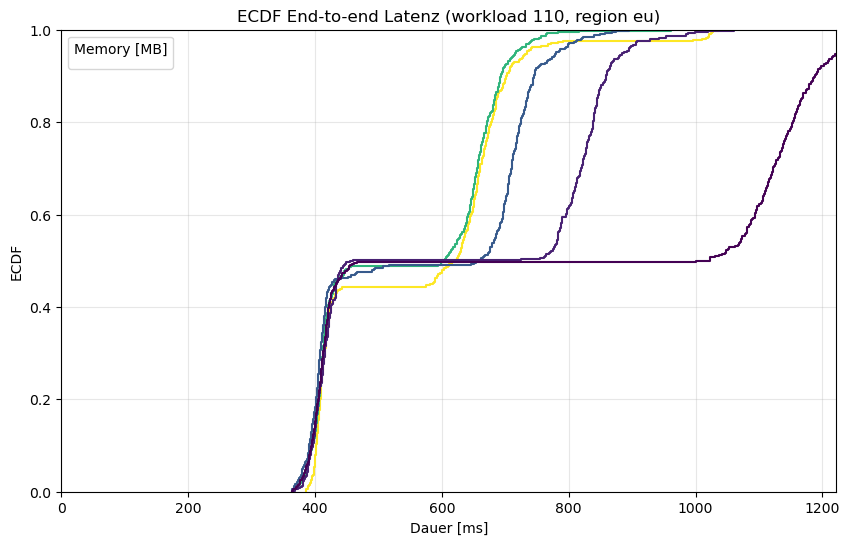

In [20]:
import seaborn as sns

import matplotlib.pyplot as plt
 
# Beispiel-Fokus: workload '110' in Region 'eu'

df_plot = df_clean[(df_clean['workload']=='110') & (df_clean['region']=='eu')].copy()
 
plt.figure(figsize=(10,6))

sns.ecdfplot(

    data=df_plot,

    x='duration_ms',

    hue='memory',

    palette='viridis',

)

plt.xlim(0, df_plot['duration_ms'].quantile(0.99))  # Fokus auf 99%-Bereich

plt.title('ECDF End-to-end Latenz (workload 110, region eu)')

plt.xlabel('Dauer [ms]')

plt.ylabel('ECDF')

plt.legend(title='Memory [MB]')

plt.grid(True, alpha=0.3)

plt.show()

 

In [17]:
alle_daten = []

for datei in dateien:
    pfad = os.path.join(verzeichnis, datei)

    # Anbietername aus dem Teil vor dem ersten "_"
    anbietername = datei.split("_")[0].lower()

    # Nur zulässige Anbieter behalten
    if anbietername not in ['aws', 'azure', 'gcp']:
        print(f"Datei übersprungen (ungültiger Anbietername): {datei}")
        continue

    if "cold" in datei.lower():
        aufruftyp = "cold"
    elif "warm" in datei.lower():
        aufruftyp = "warm"
    else:
        aufruftyp = "unbekannt"
        
    experiment_code_match = re.search(r'(\d{3})', datei)
    experiment_code = experiment_code_match.group(1) if experiment_code_match else "unbekannt"

    try:
        with open(pfad, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for invocations in data.get("_invocations", {}).values():
            for req_id, details in invocations.items():
                result = details.get("output", {}).get("result", {})
                messung = result.get("measurement")
                if not messung:
                    continue

                zeit = details.get("times", {}).get("client_begin")

                alle_daten.append({
                    "anbieter": anbietername,
                    "aufruf": aufruftyp,
                    "experiment": experiment_code,
                    "datei": datei,
                    "request_id": req_id,
                    "zeit": zeit,
                    "compute_time": messung.get("compute_time"),
                    "download_time": messung.get("download_time"),
                    "upload_time": messung.get("upload_time"),
                    "benchmark_time": details.get("times", {}).get("benchmark"),
                    "client_time": details.get("times", {}).get("client"),
                    "failure": details.get("stats", {}).get("failure", None),
                })

    except Exception as e:
        print(f"!!! Fehler beim Einlesen von {datei}: {e}")

# DataFrame erstellen
df = pd.DataFrame(alle_daten)
df['zeit'] = pd.to_datetime(df['zeit'], errors='coerce')

!!! Fehler beim Einlesen von aws_us_110_cold_results_256.json: Expecting value: line 1 column 1 (char 0)


In [10]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


messwerte = ['compute_time', 'download_time', 'upload_time']
df_clean = remove_outliers_iqr(df, messwerte)

# Vorschau
df_clean.tail()


,anbieter,aufruf,experiment,datei,request_id,zeit,compute_time,download_time,upload_time,benchmark_time,client_time,failure,outlier_compute,outlier_download,outlier_upload
18725,gcp,warm,311,gcp_311_warm_results_512.json,s6yykzp48ojc,2025-05-22 19:56:41.719776,1684818.0,1513501.0,608044.0,3806828,4008658,False,False,False,False
18731,gcp,warm,311,gcp_311_warm_results_512.json,s6yyqqzu90xt,2025-05-22 19:55:36.122865,1588418.0,1431747.0,638051.0,3658709,3850348,False,False,False,True
18732,gcp,warm,311,gcp_311_warm_results_512.json,s6yysc8n8ilp,2025-05-22 19:50:13.163906,1604868.0,1555011.0,654515.0,3814838,4015781,False,False,False,True
18734,gcp,warm,311,gcp_311_warm_results_512.json,sn3o14nzhyhu,2025-05-22 19:55:36.123815,1300510.0,1480794.0,647216.0,3429164,3645929,False,False,False,True
18758,gcp,warm,311,gcp_311_warm_results_512.json,wj7e32h0hfif,2025-05-22 19:56:41.723236,1193805.0,1393630.0,625604.0,3213650,3434153,False,False,False,True


In [11]:
def iqr_outlier_filter(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

df['outlier_compute'] = iqr_outlier_filter(df['compute_time'])
df['outlier_download'] = iqr_outlier_filter(df['download_time'])
df['outlier_upload'] = iqr_outlier_filter(df['upload_time'])

df_ausreisser = df[df[['outlier_compute', 'outlier_download', 'outlier_upload']].any(axis=1)]

df_ausreisser[['anbieter', 'zeit', 'compute_time', 'download_time', 'upload_time', 'datei']]


,anbieter,zeit,compute_time,download_time,upload_time,datei
2418,aws,2025-05-22 13:09:02.942459,17523270.0,816899.0,237185.0,aws_eu_220_cold_results_256.json
2419,aws,2025-05-22 13:04:25.241345,17360805.0,840541.0,196095.0,aws_eu_220_cold_results_256.json
2420,aws,2025-05-22 13:07:19.193461,17223698.0,877471.0,161597.0,aws_eu_220_cold_results_256.json
2421,aws,2025-05-22 13:04:25.241241,17122635.0,799007.0,262975.0,aws_eu_220_cold_results_256.json
2422,aws,2025-05-22 13:10:12.547957,17383908.0,798321.0,249016.0,aws_eu_220_cold_results_256.json
...,...,...,...,...,...,...
18772,gcp,2025-05-22 19:54:00.845493,1725521.0,1637901.0,821386.0,gcp_311_warm_results_512.json
18773,gcp,2025-05-22 19:49:19.477602,1622990.0,1785356.0,826292.0,gcp_311_warm_results_512.json
18774,gcp,2025-05-22 19:50:13.165251,1834202.0,1758482.0,888826.0,gcp_311_warm_results_512.json
18775,gcp,2025-05-22 19:56:23.711266,1502601.0,1886123.0,1094507.0,gcp_311_warm_results_512.json


In [13]:
print(df_clean['anbieter'].value_counts())


aws      10075
gcp       3414
azure     2388
Name: anbieter, dtype: int64


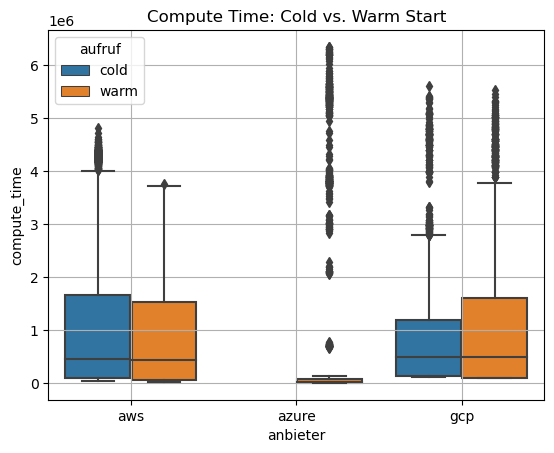

In [14]:
sns.boxplot(data=df_clean, x="anbieter", y="compute_time", hue="aufruf")
plt.title("Compute Time: Cold vs. Warm Start")
plt.grid(True)
plt.show()


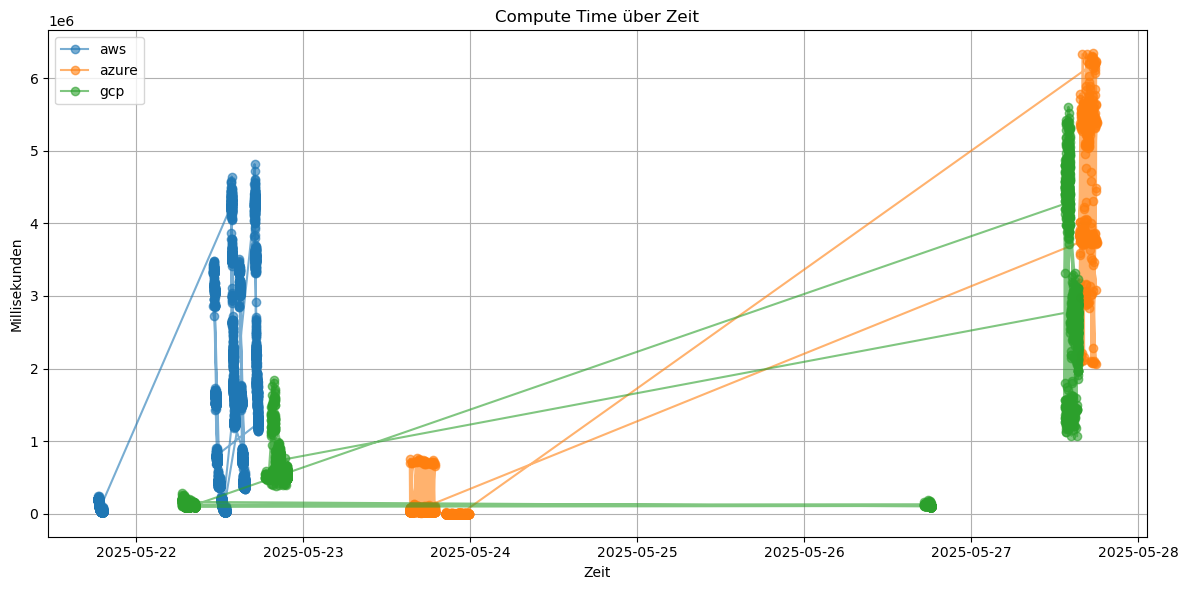

In [15]:
df_clean['zeit'] = pd.to_datetime(df['zeit'])

plt.figure(figsize=(12, 6))
for anbieter in df_clean['anbieter'].unique():
    teil = df_clean[df_clean['anbieter'] == anbieter]
    plt.plot(teil['zeit'], teil['compute_time'], label=anbieter, marker='o', linestyle='-', alpha=0.6)

plt.title("Compute Time über Zeit")
plt.ylabel("Millisekunden")
plt.xlabel("Zeit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Experiment 120
aws      4035
gcp      1626
azure    1014
Name: anbieter, dtype: int64


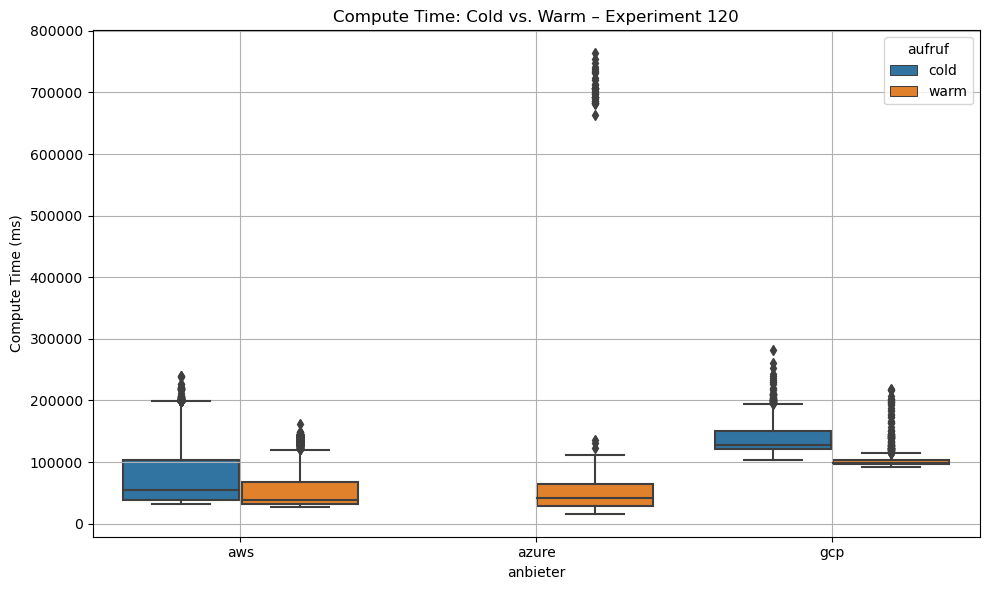


Experiment 220
aws      2409
gcp       818
azure     361
Name: anbieter, dtype: int64


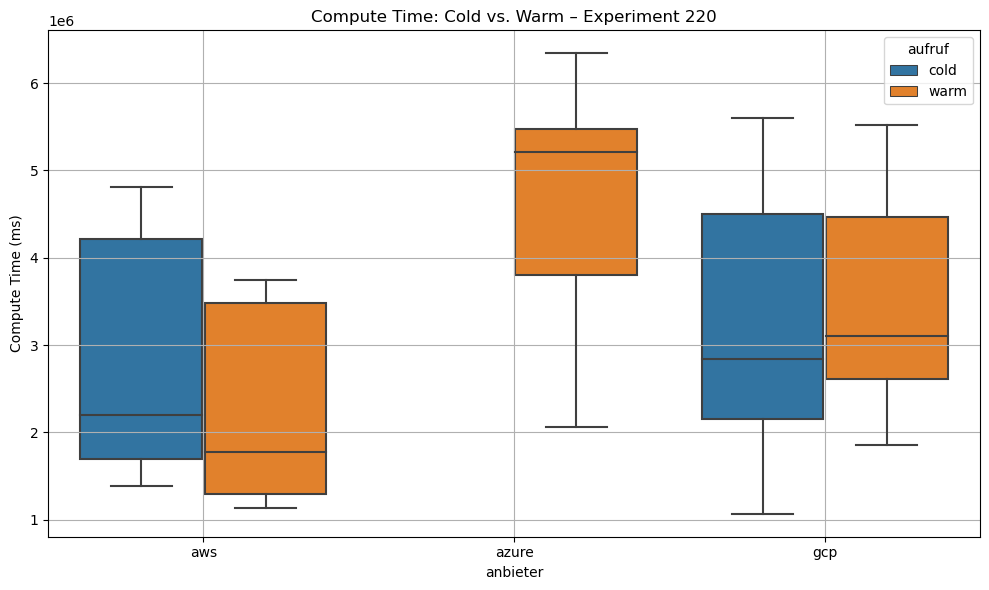


Experiment 311
aws      3631
azure    1013
gcp       970
Name: anbieter, dtype: int64


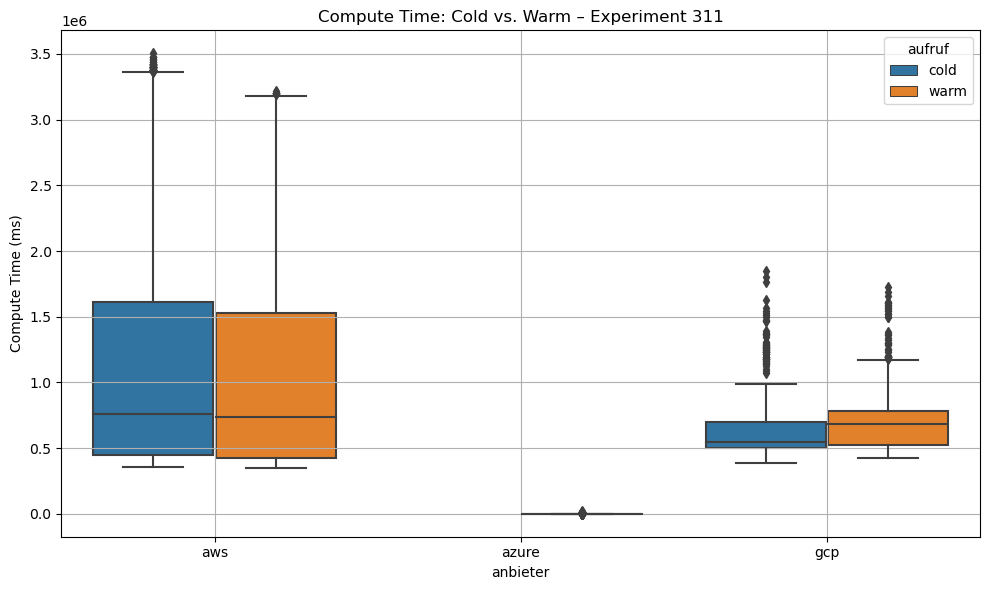

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Alle eindeutigen experiment_code werte sortieren
experimente = sorted(df_clean['experiment'].dropna().unique())

for exp_code in experimente:
    print(f"\nExperiment {exp_code}")
    
    df_exp = df_clean[df_clean['experiment'] == exp_code]
    
    # Anbieterhäufigkeit anzeigen
    print(df_exp['anbieter'].value_counts())
    
    # Boxplot erzeugen (inkl interquartil, median)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")
    plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
    plt.ylabel("Compute Time (ms)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
# Berechnung der Schwellenwerte pro gruppe
thresholds = (
    df_exp.groupby(["anbieter", "aufruf"])["compute_time"]
    .apply(lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))
    .reset_index(name="threshold")
)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data_clean=df_exp, x="anbieter", y="compute_time", hue="aufruf")

# Schwellenwerte einzeichnen
for i, row in thresholds.iterrows():
    anbieter = row["anbieter"]
    aufruf = row["aufruf"]
    thresh = row["threshold"]

    # Position auf der x-Achse finden (entsprechend der Boxplot-Darstellung)
    # Dafür bestimmen wir, wie viele Kategorien es gibt und wo die Linien gezeichnet werden sollen
    hue_levels = df_exp["aufruf"].unique()
    x_base = list(df_exp["anbieter"].unique()).index(anbieter)
    hue_offset = list(hue_levels).index(aufruf) / len(hue_levels) - 0.5 + 1 / (2 * len(hue_levels))
    x_pos = x_base + hue_offset

    plt.hlines(y=thresh, xmin=x_pos - 0.1, xmax=x_pos + 0.1, colors="red", linestyles="--")

plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
plt.ylabel("Compute Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Could not interpret input 'anbieter'

<Figure size 1000x600 with 0 Axes>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nur Experiment 110 auswählen
exp_code = 110
df_exp = df_clean[df_clean['experiment'] == exp_code]

# Anbieterhäufigkeit anzeigen
print(f"\nExperiment {exp_code}")
print(df_exp['anbieter'].value_counts())

# Schwellenwerte berechnen
thresholds = (
    df_exp.groupby(["anbieter", "aufruf"])["compute_time"]
    .apply(lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))
    .reset_index(name="threshold")
)

# Boxplot zeichnen
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")

# Schwellenwerte als rote gestrichelte Linien anzeigen
hue_levels = df_exp["aufruf"].unique()
anbieter_levels = df_exp["anbieter"].unique()

for _, row in thresholds.iterrows():
    anbieter = row["anbieter"]
    aufruf = row["aufruf"]
    thresh = row["threshold"]

    x_base = list(anbieter_levels).index(anbieter)
    hue_index = list(hue_levels).index(aufruf)
    hue_count = len(hue_levels)
    offset = (hue_index - (hue_count - 1) / 2) / hue_count
    x_pos = x_base + offset

    # Linie zeichnen
    plt.hlines(y=thresh, xmin=x_pos - 0.1, xmax=x_pos + 0.1, colors="red", linestyles="--")
    # Optional: Schwellenwert als Text
    plt.text(x_pos, thresh + 2, f"{thresh:.1f}", color="red", ha="center", fontsize=8)

plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
plt.ylabel("Compute Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()



Experiment 110
Series([], Name: anbieter, dtype: int64)


C:\Users\unger\AppData\Local\Temp\ipykernel_20080\1542787791.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))


ValueError: min() arg is an empty sequence

<Figure size 1000x600 with 0 Axes>

In [23]:
print(df_clean['experiment'].unique())
print(df_clean[df_clean['experiment'] == 110])


['120' '220' '311']
Empty DataFrame
Columns: [anbieter, aufruf, experiment, datei, request_id, zeit, compute_time, download_time, upload_time, benchmark_time, client_time, failure, outlier_compute, outlier_download, outlier_upload]
Index: []


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

exp_code = "110"  # als String
df_exp = df_clean[df_clean['experiment'] == exp_code]

# 2. Nur vollständige Zeilen behalten
df_exp = df_exp.dropna(subset=["anbieter", "compute_time", "aufruf"])

# 3. Sicherstellen, dass Daten für Plot vorhanden sind
if df_exp.empty:
    print(f"[Experiment {exp_code}] Keine gültigen Daten vorhanden.")
else:
    print(f"\nExperiment {exp_code}")
    print(df_exp['anbieter'].value_counts())

    # 4. Schwellenwerte berechnen (ohne group_keys)
    thresholds = []
    grouped = df_exp.groupby(["anbieter", "aufruf"])
    for (anbieter, aufruf), group in grouped:
        if group["compute_time"].empty:
            continue
        q1 = group["compute_time"].quantile(0.25)
        q3 = group["compute_time"].quantile(0.75)
        iqr = q3 - q1
        threshold = q3 + 1.5 * iqr
        thresholds.append({
            "anbieter": anbieter,
            "aufruf": aufruf,
            "threshold": threshold
        })

    thresholds_df = pd.DataFrame(thresholds)

    # 5. Plot erstellen
    plt.figure(figsize=(10, 6))
    try:
        sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")
    except ValueError as e:
        print("Fehler beim Zeichnen des Boxplots:", e)
    else:
        # 6. Schwellenwerte einzeichnen
        hue_levels = df_exp["aufruf"].dropna().unique()
        anbieter_levels = df_exp["anbieter"].dropna().unique()

        for _, row in thresholds_df.iterrows():
            anbieter = row["anbieter"]
            aufruf = row["aufruf"]
            thresh = row["threshold"]

            x_base = list(anbieter_levels).index(anbieter)
            hue_index = list(hue_levels).index(aufruf)
            hue_count = len(hue_levels)
            offset = (hue_index - (hue_count - 1) / 2) / hue_count
            x_pos = x_base + offset

            plt.hlines(y=thresh, xmin=x_pos - 0.1, xmax=x_pos + 0.1, colors="red", linestyles="--")
            plt.text(x_pos, thresh + 2, f"{thresh:.1f}", color="red", ha="center", fontsize=8)

        plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
        plt.ylabel("Compute Time (ms)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


[Experiment 110] Keine gültigen Daten vorhanden.


In [1]:
df['anbieter_aufruf'] = df['anbieter'].str.upper() + " - " + df['aufruf'].str.capitalize()

df.boxplot(column="compute_time", by="anbieter_aufruf", figsize=(10, 6))
plt.title("Compute Time – Verteilung pro Anbieter und Aufrufart")
plt.suptitle("")  # optional leer lassen
plt.ylabel("Millisekunden")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined